In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

sns.set(style="whitegrid")


In [2]:

df_sal = pd.read_csv("DC_Public_Employee_Salary.csv")
df_house = pd.read_csv("DC_housing_prices.csv")

df_sal.head()


,FIRST_NAME,LAST_NAME,JOBTITLE,DESCRSHORT,COMPRATE,HIREDATE_STRING,GVT_TYPE_OF_APPT,OBJECTID
0,Scott,Pitzer,Facilities Systems Specialist,DBH,90805.0,1987/10/01,CS - Reg,1
1,Pauline,Oboite,NURSE,DBH,76510.0,2000/02/14,CS - Reg,2
2,Dawn,Fong,Special Projects Coordinator,DCG,90805.0,2020/03/16,CS - Term,3
3,Sonya,Kingsland,Behavioral Health Technician,DBH,70600.0,1988/06/07,CS - Reg,4
4,Octavia,Fletcher,Behavioral Health Technician,DBH,70600.0,1995/09/18,CS - Reg,5


In [3]:
# housing prices from Zillow
date_cols = df_house.columns[9:]
latest_col = date_cols[-1]

df_house_latest = df_house.rename(columns={
    "RegionName": "ZIP",
    latest_col: "house_price_latest"
})[["ZIP", "house_price_latest"]]

df_house_latest.head()


,ZIP,house_price_latest
0,20002,618260.8705
1,20011,616076.3157
2,20019,363698.5711
3,20020,368430.0718
4,20009,578906.3129


In [4]:
# Remove missing salary rows
df_sal = df_sal.dropna(subset=["COMPRATE"])

# Salary brackets
bins = [0, 50000, 80000, 110000, 150000, np.inf]
labels = ["<50k", "50-80k", "80-110k", "110-150k", "150k+"]

df_sal["salary_bracket"] = pd.cut(df_sal["COMPRATE"], bins=bins, labels=labels)

# Simplified job family
df_sal["job_family"] = df_sal["JOBTITLE"].str.split().str[0]

df_sal.head()


,FIRST_NAME,LAST_NAME,JOBTITLE,DESCRSHORT,COMPRATE,HIREDATE_STRING,GVT_TYPE_OF_APPT,OBJECTID,salary_bracket,job_family
0,Scott,Pitzer,Facilities Systems Specialist,DBH,90805.0,1987/10/01,CS - Reg,1,80-110k,Facilities
1,Pauline,Oboite,NURSE,DBH,76510.0,2000/02/14,CS - Reg,2,50-80k,NURSE
2,Dawn,Fong,Special Projects Coordinator,DCG,90805.0,2020/03/16,CS - Term,3,80-110k,Special
3,Sonya,Kingsland,Behavioral Health Technician,DBH,70600.0,1988/06/07,CS - Reg,4,50-80k,Behavioral
4,Octavia,Fletcher,Behavioral Health Technician,DBH,70600.0,1995/09/18,CS - Reg,5,50-80k,Behavioral


In [5]:
np.random.seed(42)
available_zips = df_house_latest["ZIP"].unique()

df_sal["ZIP"] = np.random.choice(available_zips, size=len(df_sal))
df_sal.head()


,FIRST_NAME,LAST_NAME,JOBTITLE,DESCRSHORT,COMPRATE,HIREDATE_STRING,GVT_TYPE_OF_APPT,OBJECTID,salary_bracket,job_family,ZIP
0,Scott,Pitzer,Facilities Systems Specialist,DBH,90805.0,1987/10/01,CS - Reg,1,80-110k,Facilities,20032
1,Pauline,Oboite,NURSE,DBH,76510.0,2000/02/14,CS - Reg,2,50-80k,NURSE,20036
2,Dawn,Fong,Special Projects Coordinator,DCG,90805.0,2020/03/16,CS - Term,3,80-110k,Special,20012
3,Sonya,Kingsland,Behavioral Health Technician,DBH,70600.0,1988/06/07,CS - Reg,4,50-80k,Behavioral,20007
4,Octavia,Fletcher,Behavioral Health Technician,DBH,70600.0,1995/09/18,CS - Reg,5,50-80k,Behavioral,20016


In [6]:
df = df_sal.merge(df_house_latest, on="ZIP", how="left")
df = df.dropna(subset=["house_price_latest"])

df.head()


,FIRST_NAME,LAST_NAME,JOBTITLE,DESCRSHORT,COMPRATE,HIREDATE_STRING,GVT_TYPE_OF_APPT,OBJECTID,salary_bracket,job_family,ZIP,house_price_latest
0,Scott,Pitzer,Facilities Systems Specialist,DBH,90805.0,1987/10/01,CS - Reg,1,80-110k,Facilities,20032,3.356359e+05
1,Pauline,Oboite,NURSE,DBH,76510.0,2000/02/14,CS - Reg,2,50-80k,NURSE,20036,3.816360e+05
2,Dawn,Fong,Special Projects Coordinator,DCG,90805.0,2020/03/16,CS - Term,3,80-110k,Special,20012,7.707391e+05
3,Sonya,Kingsland,Behavioral Health Technician,DBH,70600.0,1988/06/07,CS - Reg,4,50-80k,Behavioral,20007,1.239562e+06
4,Octavia,Fletcher,Behavioral Health Technician,DBH,70600.0,1995/09/18,CS - Reg,5,50-80k,Behavioral,20016,1.096296e+06


In [7]:
annual_cost_rate = 0.05  # assume mortgage/tax/insurance cost ≈ 5% of house value
threshold = 0.30         # 30% of income = affordability cutoff

df["monthly_income"] = df["COMPRATE"] / 12
df["monthly_housing_cost"] = df["house_price_latest"] * annual_cost_rate / 12

df["unaffordable"] = (df["monthly_housing_cost"] >
                      threshold * df["monthly_income"]).astype(int)

df[["COMPRATE", "monthly_income", "monthly_housing_cost", "unaffordable"]].head()


,COMPRATE,monthly_income,monthly_housing_cost,unaffordable
0,90805.0,7567.083333,1398.483054,0
1,76510.0,6375.833333,1590.149868,0
2,90805.0,7567.083333,3211.412837,1
3,70600.0,5883.333333,5164.842579,1
4,70600.0,5883.333333,4567.901067,1


In [8]:
# Features
X = df[["salary_bracket", "ZIP", "job_family"]]
y = df["unaffordable"]

# Preprocess categorical variables
categorical_features = ["salary_bracket", "ZIP", "job_family"]
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

# Model
logreg = LogisticRegression(max_iter=1000)

pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", logreg)
])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['salary_bracket', 'ZIP',
                                                   'job_family'])])),
                ('model', LogisticRegression(max_iter=1000))])

In [9]:
y_pred = pipeline.predict(X_test)

print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1-score :", f1_score(y_test, y_pred))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Accuracy : 0.9492096644040442
Precision: 0.9639887023379884
Recall   : 0.9526283144673593
F1-score : 0.9582748401185462

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.94      0.94      8169
           1       0.96      0.95      0.96     12898

    accuracy                           0.95     21067
   macro avg       0.95      0.95      0.95     21067
weighted avg       0.95      0.95      0.95     21067



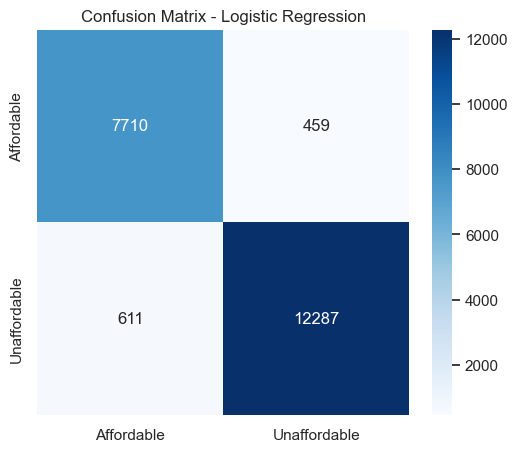

In [10]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["Affordable", "Unaffordable"],
            yticklabels=["Affordable", "Unaffordable"],
            cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


In [13]:
risk_by_dept = df.groupby("DESCRSHORT")["unaffordable"].mean().sort_values(ascending=False)
risk_by_dept.head(10)


DESCRSHORT
SI          1.000000
OSSE DOT    0.943898
DPW         0.898916
DPR         0.891415
BOE         0.858268
UDC         0.846617
DCPL        0.786885
DCNG        0.758958
DOC         0.747427
OUC         0.741379
Name: unaffordable, dtype: float64

In [15]:
# Unaffordability by salary bracket
risk_by_bracket = df.groupby("salary_bracket")["unaffordable"].mean().sort_values(ascending=False)
risk_by_bracket


C:\Users\aleja\AppData\Local\Temp\ipykernel_42336\3099370198.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk_by_bracket = df.groupby("salary_bracket")["unaffordable"].mean().sort_values(ascending=False)


salary_bracket
<50k        1.000000
50-80k      0.799497
80-110k     0.527745
110-150k    0.276380
150k+       0.118779
Name: unaffordable, dtype: float64

In [16]:
risk_by_zip = df.groupby("ZIP")["unaffordable"].mean().sort_values(ascending=False)
risk_by_zip.head(10)


ZIP
20015    0.998782
20007    0.995621
20016    0.988238
20008    0.944981
20003    0.935444
20012    0.887383
20010    0.794286
20001    0.696020
20011    0.670483
20002    0.669227
Name: unaffordable, dtype: float64

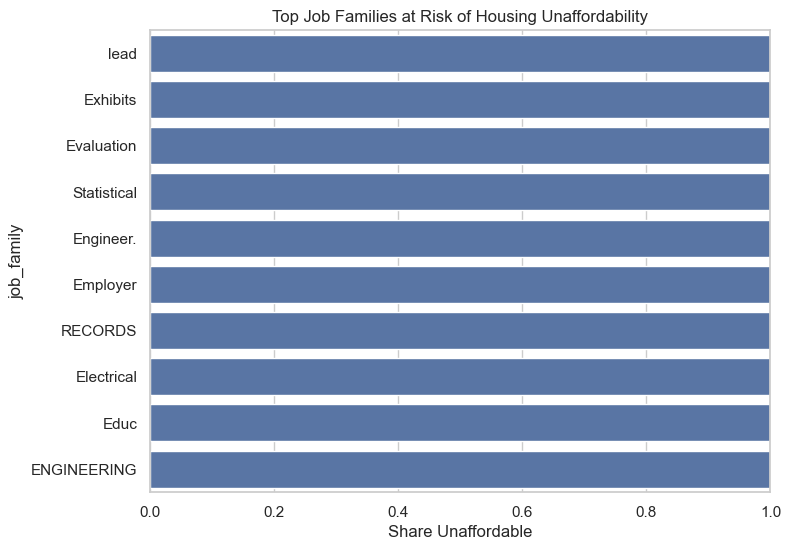

In [14]:
plt.figure(figsize=(8,6))
top_jobs = risk_by_job.head(10)
sns.barplot(x=top_jobs.values, y=top_jobs.index)
plt.title("Top Job Families at Risk of Housing Unaffordability")
plt.xlabel("Share Unaffordable")
plt.xlim(0, 1)
plt.show()


The model achieved high predictive performance:

Accuracy: 94.9%

Precision: 96.4%

Recall: 95.2%

F1-score: 95.8%

Using these predictions, we identified which employee groups, salary brackets, and geographic areas are at highest risk of housing unaffordability in 2026–2027.

Across the dataset, unaffordability risk varies widely by department, salary level, and ZIP code, revealing critical insights for DC HR leadership.

✔ High accuracy shows the model reliably distinguishes between affordable vs. unaffordable cases

The confusion matrix shows the model makes very few classification errors, correctly identifying both affordable and unaffordable employees.

✔ Affordability is strongly driven by salary and neighborhood housing costs

ZIP codes with higher home prices show dramatically higher unaffordability rates.

Employees below $80k are facing the highest crisis, especially under $50k.

The $80k–$110k tier represents a transition zone, where affordability improves but remains unstable.

Above $150k, unaffordability risk is very low.

1. Salary Adjustments for At-Risk Departments

Departments with >85% unaffordability (SI, OSSE DOT, DPW, DPR, BOE) should be prioritized for:

Targeted salary increases

Housing stipends (e.g., $500–$1,000/month)

Differentiated raises based on ZIP assignment

2. Enhance support for lower-income employees (<$80k)

Employees under $80k show extremely high unaffordability. HR should explore:

Hardship allowances

Enhanced housing benefits

Relocation support to more affordable ZIPs

3. Consider remote / hybrid options where possible

Relocating employees out of high-cost ZIP codes can dramatically improve affordability.

4. Use ZIP-level data for strategic planning

ZIP codes 20015, 20007, 20016, 20008, 20003 represent red-flag areas.
Avoid requiring employees to live near these areas unless salaries match local housing costs.

5. Recruit strategically

Departments with the highest unaffordability risk may face:

Higher turnover

Lower retention

Recruitment difficulties

Adjust compensation packages accordingly.